In [58]:
import numpy as np
import optics.aperture as ap
import optics.mtf as mtf
import image.arrayplot as aplt
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import time
%matplotlib inline

In [2]:
# this calculates an aperture on a grid with mtf convolution
# aperture values are 1 for full transmission
def simulate_aperture(array, mtfkern, pos, qsamp, qcenter, qrad, qsmooth, qdistortion):
    ap.aperture_dist3_grid(array, pos, qsamp, qcenter, qrad, qsmooth, qdistortion)
    array[...] = np.abs( np.fft.ifft2( np.fft.fft2(array * array) * mtfkern ) )
    return 0
def aperture_image_sdif(image_ref, image_sim, image_msk, mtfkern, qsamp, params):
    nprm = params.size
    c = np.array([0.,0.])
    simulate_aperture(image_sim, mtfkern, params[0:2], qsamp, c, params[2], params[3], params[4:nprm])
    return np.sum(((image_sim - image_ref) * image_msk)**2) # return squared difference of masked pixels   

In [3]:
sworkdir = 'F:/Data/Measurements/Methods/mrstem/190418-MW-0447/'

- number of mtf values:  129
- Nyquist index:  127
- extrapolation to f = 1.0 , index = 257


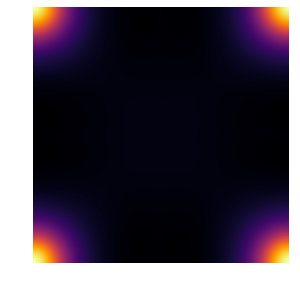

In [4]:
# experimental parameters
ndim = np.array([256,256])
arot = -12.1/180.*np.pi
rm = np.array([[np.cos(arot), -np.sin(arot)], [np.sin(arot), np.cos(arot)]])
sq1 = np.array([[0.264025, 0.000831018],[0., 0.263445]])
sq2 = np.dot(rm,sq1)
q0 = np.array([0.,0.])
p0 = ndim / 2
smtf = sworkdir + 'Merlin-300keV-SPCM100.mtf'
lmtf = mtf.loadmtf(smtf)
amtf = mtf.getmtfkernel(lmtf,ndim,1.)
plotmtf = aplt.arrayplot2d(amtf, 1, 'inferno')
ar1 = np.zeros(amtf.shape)

- total original counts: 67561.48434505642
- original center (mean, std. dev., var.): [1.05487217e+01 9.31809649e-02 8.68269221e-03]
- rescaled center (mean, std. dev., var.): [1.00000000e+00 8.83338922e-03 7.80287652e-05]


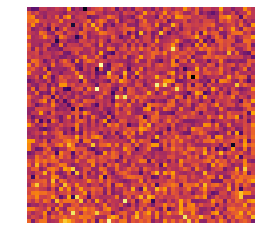

In [5]:
# load experimental image
aexp0 = np.fromfile(sworkdir + 'vac/vac_3_avg.dat', dtype='float64').reshape(ndim)
rngc = np.array([[97, 151], [97, 154]])
aexp0c = aexp0[rngc[0,0]:rngc[0,1],rngc[1,0]:rngc[1,1]]
mexp0c = np.mean(aexp0c.reshape(aexp0c.size))
vexp0c = np.var(aexp0c.reshape(aexp0c.size))
aexp1 = aexp0 / mexp0c # changed intensity to mean aperture transmission of 1 -> fit to this set of data
aexp1c = aexp1[rngc[0,0]:rngc[0,1],rngc[1,0]:rngc[1,1]]
mexp1c = np.mean(aexp1c.reshape(aexp1c.size))
vexp1c = np.var(aexp1c.reshape(aexp1c.size))
plotexpcenter = aplt.arrayplot2d(aexp0c, 4, 'inferno')
print("- total original counts:", np.sum(aexp0))
print("- original center (mean, std. dev., var.):", np.array([mexp0c, np.sqrt(vexp0c),vexp0c]))
print("- rescaled center (mean, std. dev., var.):", np.array([mexp1c, np.sqrt(vexp1c),vexp1c]))

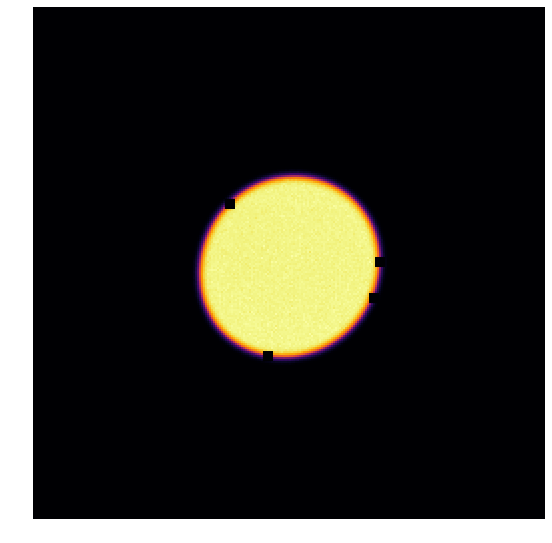

In [6]:
amsk0 = np.full(amtf.shape, 1)
amsk1 = amsk0
pmsk = np.array([[157,98,2],[110,170,2],[128,173,2],[81,117,2]]) # ! set pixel blocks to mask [col,row,size]
for i in range(0, pmsk.shape[0]):
    amsk1[pmsk[i,0]-pmsk[i,2]:pmsk[i,0]+pmsk[i,2]+1,pmsk[i,1]-pmsk[i,2]:pmsk[i,1]+pmsk[i,2]+1] = 0
plotmsk = aplt.arrayplot2d((aexp1*amsk1),2,'inferno')

Elapsed time [s] : 1.4059300422668457


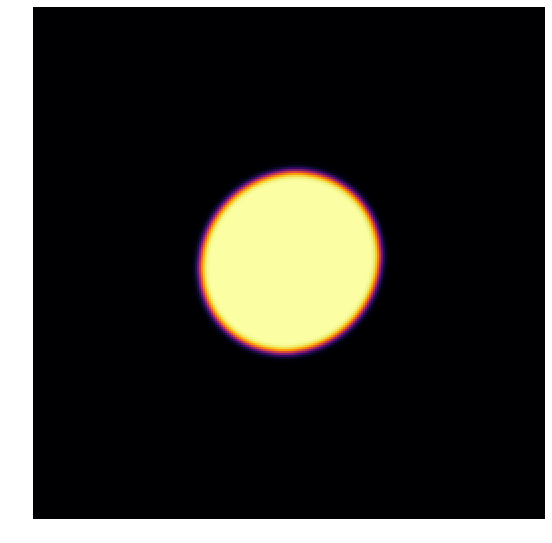

In [7]:
# test simulation
# - set parameters
apr = 11.95
aps = 0.3
#qd = np.array([0.150036, 0.376273, 0.0186035, 0.0277298, -0.00230719, 0.10082])
qd = np.array([0.15, 0.38, 0.0, 0.0, 0.0, 0.0])
# - calculate
start = time.time()
simulate_aperture(ar1,amtf,p0,sq2,q0,apr,aps,qd)
end = time.time()
print('Elapsed time [s] :' , (end - start))
# - plot
plota = aplt.arrayplot2d(ar1, 2, 'inferno')

[ 1.27700e+02  1.25600e+02  1.19500e+01  3.14000e-01  1.50036e-01
  3.76273e-01  1.86035e-02  2.77298e-02 -2.30719e-03  1.00820e-01]
Elapsed time [s] : 0.15618467330932617
chi-square : 3.166111971489809


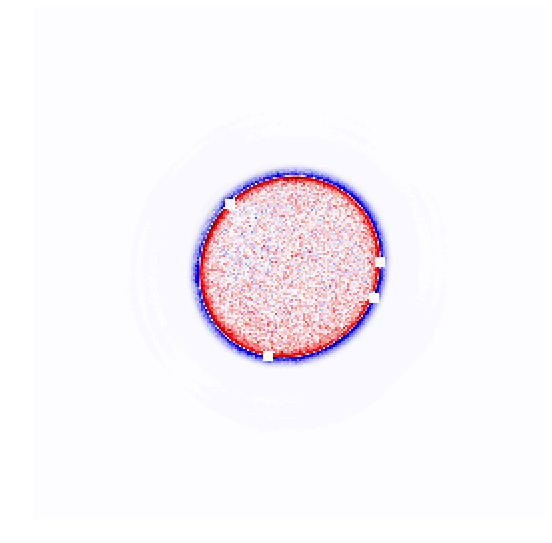

In [53]:
# test comparison
artmp = ar1
# - set parameters
p0 = np.array([127.7,125.6])
apr = 11.95
aps = 0.314
qd = np.array([0.150036, 0.376273, 0.0186035, 0.0277298, -0.00230719, 0.10082])
#qd = np.array([0.15, 0.38, 0.0, 0.0, 0.0, 0.0])
prmtmp = np.append(np.append(np.append(p0,apr),aps),qd)
print(prmtmp)
# - calculate
start = time.time()
chisq = aperture_image_sdif(aexp1, artmp, amsk1, amtf, sq2, prmtmp)
end = time.time()
print('Elapsed time [s] :' , (end - start))
print('chi-square :', chisq)
# - plot
adif = (aexp1 - artmp)*amsk1
plota = aplt.arrayplot2d(adif, 2, 'seismic', vrangetype = 'zerosym')

In [ ]:
plota.savefig(sworkdir + 'STO_3/vac_3_avg_sim_x.png', dpi=plota.dpi)

In [55]:
# Monte-Carlo optimization
np.random.seed()
# - initial state
nprm = prmtmp.size
prm0 = prmtmp
chisq0 = aperture_image_sdif(aexp1, artmp, amsk1, amtf, sq2, prmtmp)
print('initial:', prm0)
print('chi-square:', chisq)
# - stepper
dstp = 0.001
prms = np.array([1.,1.,1.,0.1,0.1,0.1,0.01,0.01,0.01,0.01])*dstp
print('step ranges:', prms)
temp = chisq0 * 0.0001 # - temperature
ntry = 200 # - number of useless trials
prmit = prm0
prmbest = prm0
csprev = chisq0
csbest = chisq0
nbest = 0
nbetter = 0
nprobacc = 0
it = 1
itsum = 1
pbar = tqdm(total=ntry)
pbar.update(1)
while it < ntry:
    prmdev = np.random.normal(size = nprm) * prms
    prmtry = prmit + prmdev
    cstry = aperture_image_sdif(aexp1, artmp, amsk1, amtf, sq2, prmtry)
    csdev = cstry - csprev
    if csdev <= 0: # improvement to previous?
        prmit = prmtry # update
        csprev = cstry # ''
        if (cstry < csbest): # even better than best ?
            prmbest = prmtry # update best
            csbest = cstry # ''
            nbest += 1
            it = 1 # reset iterator -> try to gat better at this temperature
            pbar.n = 1
            pbar.last_print_n = 1
        else:
            nbetter += 1
    else:
        win = -csdev/temp
        probacc = 0.
        if win > -200:
            probacc = min(1., np.exp(win)) # finite probability to accept 0 ... 1
        if probacc > np.random.random_sample():
            prmit = prmtry # accept worse case
            csprev = cstry # ''
            nprobacc += 1
    it += 1
    itsum += 1
    pbar.set_description('({:d}) chisq: {:.4f}'.format(itsum, csbest))
    pbar.update(1)
pbar.close()
print('final:', prmbest)
print('change:', prmbest - prm0)
print('chi-square :', csbest, ', improvement: ', 1. - csbest/chisq0)
print('total trials:', itsum)
print('best:', nbest, ', better:', nbetter, ', probably better:', nprobacc, ', rejected: ', itsum - nbest - nbetter - nprobacc)


initial: [ 1.27700e+02  1.25600e+02  1.19500e+01  3.14000e-01  1.50036e-01
  3.76273e-01  1.86035e-02  2.77298e-02 -2.30719e-03  1.00820e-01]
chi-square: 3.166111971489809
step ranges: [1.e-03 1.e-03 1.e-03 1.e-04 1.e-04 1.e-04 1.e-05 1.e-05 1.e-05 1.e-05]


final: [ 1.27651319e+02  1.25627531e+02  1.19503072e+01  2.66258521e-01
  1.49912533e-01  3.77200283e-01  1.85754743e-02  2.86419677e-02
 -1.66044495e-03  1.00999527e-01]
change: [-4.86811443e-02  2.75309431e-02  3.07193278e-04 -4.77414794e-02
 -1.23467070e-04  9.27283488e-04 -2.80256535e-05  9.12167725e-04
  6.46745049e-04  1.79526957e-04]
chi-square : 2.9778184659379274 , improvement:  0.05947152445883974
total trials: 5633
best: 514 , better: 852 , probably better: 1115 , rejected:  3152


chi-square: 2.9778184659379274
min: -0.09170121535941345 , max:  0.08169289128087498


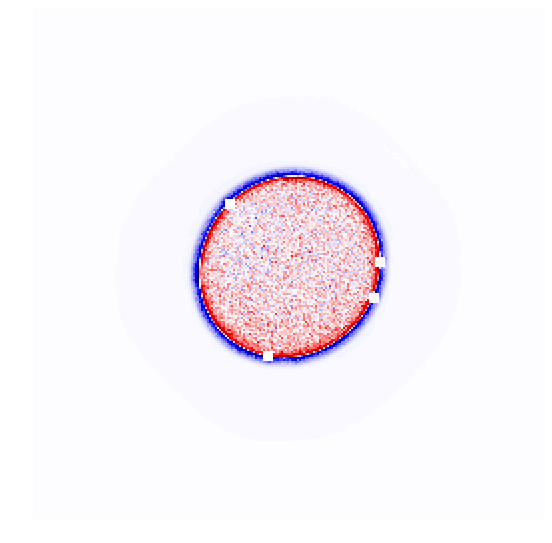

In [61]:
chisq = aperture_image_sdif(aexp1, artmp, amsk1, amtf, sq2, prmbest)
adif = (aexp1 - artmp)*amsk1
print('chi-square:', chisq)
print('min:', np.amin(adif), ', max: ', np.amax(adif))
plota = aplt.arrayplot2d(adif, 2, 'seismic', vrangetype = 'zerosym')

In [57]:
prmtmp = prmbest